In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import os

In [11]:
class heatmap:
    '''
    class heatmap : analyze the results from ouch fitting

    methods
    categorize : generate categorized dataframe based on each genes' fdr values
    sort_cell : sort the gene index
    heatmap : plot categorical heatmap using fdr values
    var : plot OU variance values in three ways (heatmap, density plot, and pearson correlation)
    '''

    def __init__(self,
                 directory
                 ):
        
        '''
        Argument
        directory(str) : directory for the files including results of ouch fitting
        '''

        self.directory = directory
        self.file_list = os.listdir(self.directory)
        self.cell = [os.path.splitext(name)[0] for name in self.file_list]

        # list of dataframes
        self.db = {}
        self.species = []
        for i in range(len(self.cell)):
            self.db[self.cell[i]] = pd.read_csv(self.directory+self.file_list[i], delimiter="\t")
            species = self.db[self.cell[i]].columns.tolist()
            if len(species) > len(self.species):
                self.species = self.db[self.cell[i]].columns.tolist()

        # gene index
        self.idx = self.db[self.cell[0]].index


    def categorize(self):
        '''
        generate categorized dataframe
        Argument : data(list of dataframe), ind(list of each organ's gene name)
        return : categorize dataframe, columns(organ) & rows(gene), ["not expressed", "stabilized selection", "neutral evolution"]
        '''

        df = pd.DataFrame()
        for i in range(len(self.file_list)):
            cat = {}
            for j in range(len(self.idx)):
                if self.db[self.cell[i]]["qvalues"][j] < 0.05:
                    cat[j] = "stabilizing selection"
                elif self.db[self.cell[i]]["qvalues"][j] > 0.05 : 
                    cat[j] = "neutral evolution"
                else: 
                    cat[j] = None
            df[self.cell[i]] = cat.values()
        df.index = self.idx

        return df
    
    
    def sort_cell(self, data, count, idx):
        '''
        sort the gene index (specific selection)

        Argument 
        data(dataframe) : categorized data 
        count(dataframe) : number of genes in each category
        idx(list) : gene index under specific selection
        '''

        col = data.columns

        count1 = {}
        for i in self.cell:
            count1[i] = []
        
        ## sort the genes
        for i in idx:
            for cell in count1.keys():
                if "stabilizing selection" == data.loc[i,cell]:
                    count1[cell].append(i)
                    break

        return count1


    def analyze_categories(self, data):

        '''
        sort the genes into three categories 
        : ubiquitous selection(all-selection), no selection, and specific selection

        Argument 
        data(dataframe) : categorized data 
        '''

        # generate count matrix
        count_mat = pd.DataFrame()
        count_mat.index = data.index
        count_mat[None] = data.apply(lambda row: row.value_counts().get(None, 0), axis=1)
        count_mat['stabilizing selection'] = data.apply(lambda row: row.value_counts().get('stabilizing selection', 0), axis=1)
        count_mat['neutral evolution'] = data.apply(lambda row: row.value_counts().get('neutral evolution', 0), axis=1)
        count_mat = count_mat.sort_values(by=['stabilizing selection','neutral evolution'], ascending=[True, False])

        # group zero selection & ubiquitous selection
        zero_stabilized = count_mat[count_mat["stabilizing selection"]==0].index.tolist()
        zero_neutral = count_mat[count_mat["neutral evolution"]==0].index.tolist()
        idx = zero_stabilized
        num_zero_stab = len(zero_stabilized)
        num_zero_neutral = len(zero_neutral)

        # group of tissue specific selection
        specific_selection = [i for i in count_mat.index if (i not in zero_stabilized) and (i not in zero_neutral)]
        count1 = self.sort_cell(data, count_mat, specific_selection)
        flattened_list = [value for sublist in count1.values() for value in sublist]
        num_count = len(flattened_list)

        # reindex the genes in the following order : zero-selection > specific-selection > all-selection
        idx.extend(flattened_list)
        idx.extend(zero_neutral)
        data = data.reindex(idx)

        return data, num_zero_stab, num_count, num_zero_neutral
    

    def heatmap(self):
        # plot categorical heatmap for the genes

        # Define a mapping dictionary for categorical to numerical values
        cat_mapping = {
            "stabilizing selection": 0,
            None: 1,
            "neutral evolution": 2
        }

        # Convert categorical values to numerical values
        cat_df = self.categorize()
        count, a, b, c = self.analyze_categories(cat_df)
        numerical_df = count.replace(cat_mapping)

        # discrete colormap (n samples from a given cmap)
        colors = ["#FFC1C1","#D3D3D3", "#C1C1FF"]
        cmap = sns.color_palette(colors, as_cmap=True)
        ax = sns.heatmap(numerical_df, cmap=cmap) 

        # Get the colorbar
        colorbar = ax.collections[0].colorbar

        # Set the tick positions and labels
        tick_positions = [1/3, 1, 5/3]
        tick_labels = ["stabilizing selection","None", "neutral evolution"]

        # Set the tick positions and labels on the colorbar
        colorbar.set_ticks(tick_positions)
        colorbar.set_ticklabels(tick_labels)  

        # ytick
        ytick_positions = [(a+b+c)-c/2, a+b/2, a/2]
        ax.set_yticks(ytick_positions)
        ytick_labels = [
            f"ubiquitous selection\n{100 * c / (a + b + c):.2f}%",
            f"specific selection\n{100 * b / (a + b + c):.2f}%",
            f"no selection\n{100 * a / (a + b + c):.2f}%"
        ]
        ax.set_yticklabels(ytick_labels)

        plt.show()



    def var(self):
        '''
        plot the ou-variance data
        '''

        # generate categorical dataframe for each gene & organ
        df = pd.DataFrame()
        for i in range(len(self.cell)):
            df[self.cell[i]] = self.db[self.cell[i]]["var"]
        df.index = self.idx
        df["mean"] = df.mean(axis=1)
        OUvar = df.sort_values(by = "mean", ascending=False)
        OUvar = OUvar.drop('mean', axis=1)

        # discrete colormap (n samples from a given cmap)
        cmap = sns.color_palette("blend:#7AB,#EDA", as_cmap=True) 
        ax = sns.heatmap(OUvar, vmin=0, vmax=0.1, cmap=cmap) 
        colorbar = ax.collections[0].colorbar   
        ax.set_yticks([])                        
        plt.show()

        ## density plot
        for i in OUvar.columns:
            sns.kdeplot(np.log(OUvar[i]),label=i)
            plt.xlabel("log(evolutionary variance)")
            plt.legend()
        plt.show()

        ## pearson correlation
        OUvar_nona = OUvar.dropna()
        corr_matrix = OUvar_nona.corr()
        # heatmap
        ax = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
        plt.show()

        return OUvar

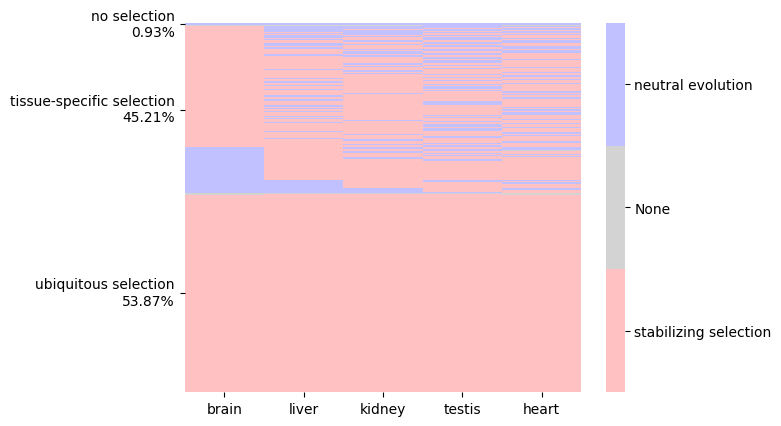

In [12]:
hm = heatmap("/Users/yunseong-eun/Desktop/processed_chen/subset/subset_OU/")
hm.heatmap()

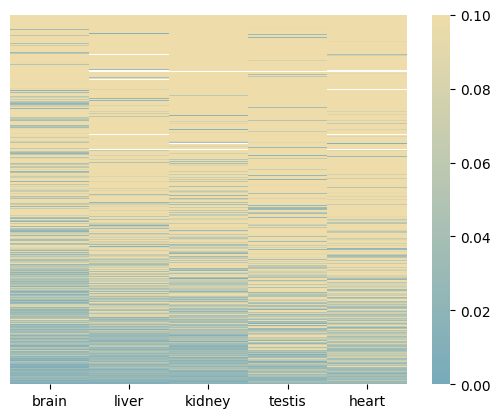

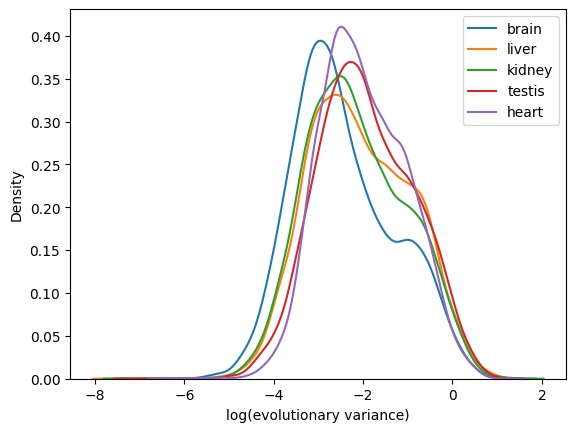

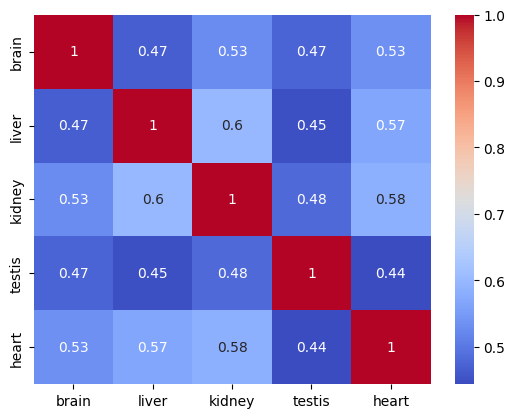

,brain,liver,kidney,testis,heart
4676,2.286306,2.577548,2.869142,0.375996,3.364796
4485,NaN,NaN,1.847459,NaN,NaN
10538,2.212119,1.943280,1.090346,1.668690,1.781878
10286,3.038434,1.126471,1.370795,1.677781,1.342887
2004,1.919003,1.666150,0.993783,1.562287,2.352057
...,...,...,...,...,...
4604,NaN,NaN,NaN,NaN,NaN
4606,NaN,NaN,NaN,NaN,NaN
4615,NaN,NaN,NaN,NaN,NaN
4618,NaN,NaN,NaN,NaN,NaN


In [13]:
hm.var()